# Parse Rule Features

* Import necessary libraries

In [1]:
import ast
from collections import Counter, defaultdict
import de_core_news_sm
import itertools
from nltk import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import re
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import spacy
import string

* Load data

In [3]:
df = pd.read_csv("datasets/08_SyntaxComplexity/01_Preprocessing_df.csv", sep="|", lineterminator = '\n')
df['Level_ABC'] = df.apply (lambda row: (row["Level"][0]),axis=1)
df = df[df.Level_ABC != "L"]
df = df[df.Type == "Writing"]
level = df.groupby('Level_ABC')
df = level.apply(lambda x: x.sample(level.size().min()).reset_index(drop=True))

In [4]:
#create two dataframes for different sources
cleg = df[df.Source == "CLEG"]
cleg = cleg[cleg.Level_ABC.isin(["B","C"])]

b_c = df[df.Source != "CLEG"]
b_c = b_c[b_c.Level_ABC.isin(["B","C"])]

level = b_c.groupby("Level_ABC")
b_c = level.apply(lambda x: x.sample(level.size().min()).reset_index(drop=True))

level_cleg = cleg.groupby("Level_ABC")
cleg = level_cleg.apply(lambda x: x.sample(level_cleg.size().min()).reset_index(drop=True))

C:\Users\Ditty\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 'Level_ABC' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
C:\Users\Ditty\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'Level_ABC' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # This is added back by InteractiveShellApp.init_path()


In [5]:
df.groupby('Level_ABC').count()

C:\Users\Ditty\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'Level_ABC' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,Level,Title,Text,Source,Type,newLevel,cleanedText,SE_ratioRealSpellingErrors,SE_ratioSpellingErrors,SE_ratioSpellingErrorsWithCorrection,SE_ratioSpellingErrorsWithoutCorrection,SE_ratioUmlautSpellingErrors,SE_ratioCapitalisationErrors,RFTagger,parsedText
Level_ABC,,,,,,,,,,,,,,,
A,549,0,549,549,549,549,549,549,549,549,549,549,549,549,549
B,549,0,549,549,549,549,549,549,549,549,549,549,549,549,549
C,549,0,549,549,549,549,549,549,549,549,549,549,549,549,549


* Get features

In [6]:
#helper functions
def get_constituent_indices(line, open_bracket = '(', closed_bracket = ')'):
    """
    helper function that yields start and end indices of constituents, ie elements enclosed in brackets
    """  
    #initialize empty stack
    stack = []
    
    #find indices between open and closed brackets
    for m in re.finditer(r'[()]'.format(open_bracket, closed_bracket), line):
        pos = m.start()        
        check = line[pos]
        if check == open_bracket:
            stack.append(pos+1)

        elif check == closed_bracket:
            if len(stack) > 0:
                prev_pos = stack.pop()
                yield (prev_pos, pos)
                
def get_rules(sentence):
    """
    funtion that takes a parsed sentence as a string as input and outputs a list of rules as strings
    """
    rules = []
    #get substrings of the string enclosed in brackets
    for openpos, closepos in get_constituent_indices(sentence):
        sub = sentence[openpos:closepos]
        #remove the closed brackets
        sub = sub.replace(")", "")
        #make string into a list
        lst = sub.split(" ")
        #ignore pre-constitents
        if len(lst) > 2:
            #check terminals in the list
            new = str([word for word in lst if word.isupper()])
            rules.append(new) 
    return rules
                
def get_text_rules(text):
    '''
    function that returns rules from one text as a list
    '''
    text_rules = []
    for ind, sentence in enumerate(ast.literal_eval(text)):
        
        if sentence != []:
            rules = get_rules(str(sentence[:-1]))
            for rule in rules:
                text_rules.append(rule)           
    return text_rules 

def get_all_rules(df):
    '''
    function that returns all rules of a dataframe as a set
    '''
    all_rules = defaultdict(int)
    for row in df.iterrows():
        rules = get_text_rules(row[1]["parsedText"])
        for rule in rules:
            all_rules[rule] += 1
            
    return set([key for key in all_rules if all_rules[key] > 10])

def create_dic(df):
    '''
    function that creates a nested dictionary of rules out of a data frames
    {index of sentence: {rule : times it occurs}}
    '''
    rules = get_all_rules(df)
    dic = defaultdict(lambda: defaultdict(int))
    for ind, row in enumerate(df.iterrows()):
        
        text_rules = get_text_rules(row[1]["parsedText"])
        if text_rules != []:
            for rule in text_rules:
                if rule in rules:
                    dic[ind][rule] += 1
        else:
            dic[ind] = []
    return dic

def feature_dicts_to_matrix(dic, df):    
    '''
    function that turns the dictionary created by the create_dic function into into a matrix   
    ''' 
    all_rules = list(get_all_rules(df))    
    feature_matrix = np.zeros((len(dic), len(all_rules))) 
 
    for ind in dic:
        for rule in dic[ind]:
            feature_matrix[ind][all_rules.index(rule)] = dic[ind][rule] 

    return feature_matrix

In [7]:
all_rules = get_all_rules(df)
print(len(all_rules))

1222


In [8]:
def get_parse_rule_features(df):
    '''
    function that returns train matrix, train levels, test matrix, test levels, feature list and the matrix for the whole df
    '''
    feature_list = [rule for rule in get_all_rules(df)]
    train, test = train_test_split(df)
    all_matrix = feature_dicts_to_matrix(create_dic(df), df)
    train_matrix = feature_dicts_to_matrix(create_dic(train), df)
    test_matrix = feature_dicts_to_matrix(create_dic(test), df)
    
    return train_matrix, train["Level_ABC"], test_matrix, test["Level_ABC"], feature_list, all_matrix

In [9]:
def train_model(df, model, get_features_function):    
    clf = model
    train_matrix, train_level, test_matrix, test_level, feature_list, all_matrix = get_features_function(df)
    clf.fit(train_matrix, train_level)
    return clf

In [10]:
def return_cross_val_scores(df, model, get_features_function):
    clf = model
    if isinstance(df, pd.DataFrame):
        return cross_val_score(clf, get_features_function(df)[5], df["Level_ABC"], cv=10)
        
    else:
        return cross_val_score(clf, df[0], df[1], cv=10)

In [11]:
def select_n_best_features(df, k):
    train_matrix, train_level, test_matrix, test_level, feature_list, all_matrix = get_parse_rule_features(df)
    model = SelectKBest(chi2, k).fit(train_matrix, train_level) 
    indices = model.get_support(indices=True)
    scores = model.scores_ 
    p_values = model.pvalues_
    X_new = model.transform(all_matrix)
    return X_new, df['Level_ABC'], indices, scores, p_values, feature_list

* Test different number of features

In [26]:
for n in [10, 20, 50]:
    new_X, new_y, indices, feature_scores, p_values, all_rules = select_n_best_features(df, n)
    scores = return_cross_val_scores((new_X, new_y), SVC(), get_parse_rule_features)
    print("Accuracy of", n, "parse rule features:", (scores).mean(), "+-",(scores).std())

Accuracy of  10  parse rule features: 0.7073737373737374 +- 0.022748811342758506
Accuracy of  20  parse rule features: 0.7322334455667788 +- 0.02162664817957132
Accuracy of  50  parse rule features: 0.7401010101010101 +- 0.021159386107514874


In [27]:
for n in [100, 200, 500]:
    new_X, new_y, indices, feature_scores, p_values, all_rules = select_n_best_features(df, n)
    scores = return_cross_val_scores((new_X, new_y), SVC(), get_parse_rule_features)
    print("Accuracy of", n, "parse rule features:", (scores).mean(), "+-",(scores).std())

Accuracy of  100  parse rule features: 0.7601346801346802 +- 0.025057020983779654
Accuracy of  200  parse rule features: 0.7661728395061729 +- 0.02830118051363292
Accuracy of  500  parse rule features: 0.7722446689113356 +- 0.03329639486501223


In [28]:
for n in ["all"]:
    new_X, new_y, indices, feature_scores, p_values, all_rules = select_n_best_features(df, n)
    scores = return_cross_val_scores((new_X, new_y), SVC(), get_parse_rule_features)
    print("Accuracy of", n, "parse rule features:", (scores).mean(), "+-",(scores).std())

Accuracy of all parse rule features: 0.7570482603815938 +- 0.030716391313898625


In [29]:
def clean_rule_up(rule):
    return re.sub(r'[^\w\s]','',rule)

In [30]:
print("Best 20 parse rules:")
new_X, new_y, indices, feature_scores, p_values, all_rules = select_n_best_features(df, 20)
pprint.pprint([clean_rule_up(all_rules[ind]) for ind in indices])

Best 20 parse rules:
['PP APPR ART ADJA NN',
 'NP PIAT NN',
 'PP APPR NN',
 'PP PROAV',
 'NP ART ADJA NN',
 'PP APPRART NN',
 'PP APPR PDAT NN',
 'AVP ADV ADV',
 'CNP NN KON NN',
 'AP ADV ADJD',
 'NP ADJA NN',
 'PP APPR ART NN',
 'NP PDAT NN',
 'NP ART NN NP ART NN',
 'NP PIDAT NN',
 'PP APPR ADJA NN',
 'PP APPR ART NN NP ART NN',
 'NP ART NN',
 'VZ PTKZU VVINF',
 'CAP ADJA KON ADJA']


* Visualize

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

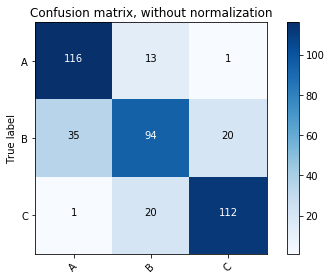

In [32]:
def select_n_best_features_for_cm(df, k):
    train_matrix, train_level, test_matrix, test_level, feature_list, all_matrix = get_parse_rule_features(df)
    model = SelectKBest(chi2, k).fit(train_matrix, train_level) 
    train_matrix_new = model.transform(train_matrix)
    test_matrix_new = model.transform(test_matrix)
    return train_matrix_new, train_level, test_matrix_new, test_level

train_matrix_new, train_level, test_matrix_new, test_level = select_n_best_features_for_cm(df, 500)
clf = SVC()
clf.fit(train_matrix_new, train_level)
level_pred = clf.predict(test_matrix_new)

cnf_matrix = confusion_matrix(test_level, level_pred)
class_names = ["A", "B", "C"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')